# **Experiment: MNIST**

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys

if ".." not in sys.path:
    sys.path.insert(0, "..")

SAVE_FIGURES = False

def savefig(fname, data_digit):
  if SAVE_FIGURES:
    plt.savefig(f'FIG/E01_{fname:s}_D{data_digit:d}.png', bbox_inches='tight', dpi=300)
    plt.savefig(f'FIG/E01_{fname:s}_D{data_digit:d}.eps', bbox_inches='tight')

## Contents
1. [Dataset](#dataset)
2. [Function collection](#function-collection)
3. [Multiplier](#multiplier)
4. [Optimal multiplier](#optimal-multiplier)
5. [Worst and best cases](#worst-and-best-cases)
6. [Extrapolation in frequency](#extrapolation-in-frequency)

## Dataset

Define first the functions in the collection in the Fourier domain.

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
X_data, X_labels = mnist["data"].to_numpy(), mnist["target"]
X_labels = X_labels.astype(int)

Restrict the data to images about a single digit. 

In [3]:
data_digit = 8
X_data = X_data[X_labels == data_digit]

Set resolution parameters.

In [4]:
# image pixels (hardcoded)
N = (28, 28)
# pixel size
dx = [ 1/N[0], 1/N[1] ]

print('Resolution')
print(f'Space        {dx[0]:.3E} x {dx[1]:.3E}')
print(f'Resolution   {N[0]:d} x {N[1]:d}')

Resolution
Space        3.571E-02 x 3.571E-02
Resolution   28 x 28


Generate the coefficient matrix ``A`` by extracting ``num_data`` random samples.  

Matrix size             500 x 784
Maximum singular value  1.699E+02
Minimum singular value  1.128E-15
Rank                    473


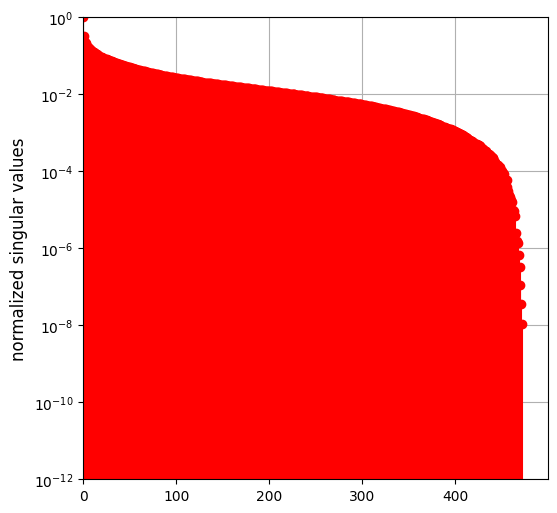

In [5]:
# this puts the origin on the lower-left corner
X_data = X_data.reshape((X_data.shape[0], N[0], N[1]))
X_data = X_data[:, ::-1, :]
# number of images
num_data = 500
# selection of images
# random
#data_index = np.random.randint(0, num_data, num_data)
# deterministic / for reproducibility
data_index = [ I for I in range(num_data) ] 
# selection of images
A = X_data[data_index].reshape((num_data, N[0] * N[1]))
A = A / 255
# conditioning
sv_A = np.linalg.svdvals(A)
# singular values to evaluate best/worst cases
rank_A = np.sum(np.where(sv_A/sv_A[0] > 1E-9, 1, 0))

print(f'Matrix size             {A.shape[0]:d} x {A.shape[1]:d}')
print(f'Maximum singular value  {sv_A[0]:.3E}')
print(f'Minimum singular value  {sv_A[-1]:.3E}')
print(f'Rank                    {rank_A:d}')

# plot
plt.figure(figsize=(6, 6))
plt.stem(range(sv_A.size), sv_A/sv_A[0], markerfmt='ro', linefmt='r-', basefmt='r-')
plt.xlim([ -0.5, sv_A.size - 0.5 ])
plt.ylim([ 1E-12, 1E0 ])
plt.ylabel('normalized singular values', fontsize=12)
plt.yscale('log')
plt.grid('both')
plt.show()

Plot the first ``36`` images.

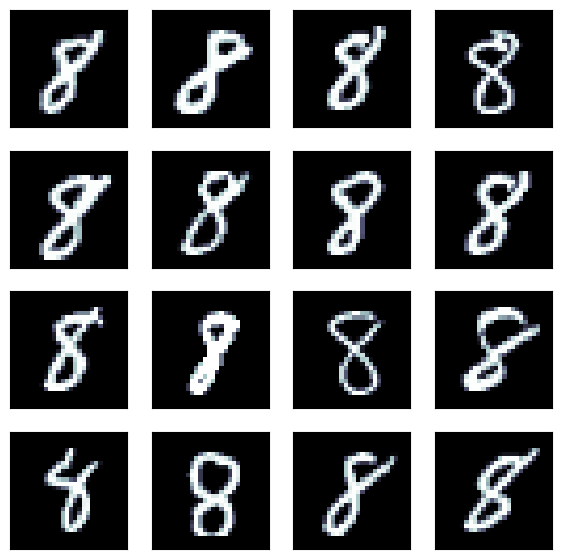

In [6]:
plt.figure(figsize=(7, 7))
for I in range(16):
  plt.subplot(4, 4, I + 1)
  plt.imshow(A[I].reshape(N), vmin=0.0, vmax=1.0, origin='lower', cmap='bone')
  plt.xticks([])
  plt.yticks([])
savefig('DATA', data_digit)
plt.show()

## Function collection

The collection $\mathcal{U}$ comprises the images extrapolated to $\mathbb{R}^2$ by using the indicator function of pixels of size $\Delta x_1 \times \Delta x_2$. The support of each function is contained on $[0, 1]\times [0, 1]$. The collection $\mathcal{F}$ is defined using using the function ``shifted_exponential_collection`` in ``routines.collections``. 

In [7]:
from adaptiveExtrapolationInFrequency.routines.collections import shifted_exponential_collection

The Fourier transform of the indicator function of each pixel is a scaled $\operatorname{sinc}$ function.

In [8]:
def basis_fourier(w):
  return dx[0] * dx[1] * np.sinc(dx[0] * w.T[0]) * np.sinc(dx[1] * w.T[1])

# location of pixels / this is the center of the pixel
xo = np.meshgrid((0.5 + np.linspace(0, N[0] - 1, N[0])) / N[0], (0.5 + np.linspace(0, N[1] - 1, N[1])) / N[1])
xo = np.vstack([ xo[0].ravel(), xo[1].ravel() ]).T

Define the vector-valued function directly.

In [9]:
f = shifted_exponential_collection(2, xo, basis_fourier, A)

## Multiplier

Define the multiplier associated to the collection. We use an annulus with $r_{\min} = 0.5$ and $r_{\max} = 2.0$. The goal is to evaluate frequency extrapolation to a disk or radius $r_{\operatorname{hi}} = 8.0$ from a disk of radius $r_{\operatorname{lo}} = 2.0$. In this case the extrapolation is *isotropic*.

In [ ]:
from adaptiveExtrapolationInFrequency.objects.domain import Annulus2D, Circle2D
from adaptiveExtrapolationInFrequency.objects.multiplier import SMultiplier

In [11]:
# minimum frequency
rmin = 0.5
# maximum frequency
rmax = 2.0
# superresolution factor
alpha = 4.0

# low-resolution domain
DC_lo = Circle2D(r = rmax)
# high-resolution domain
DC_hi = Circle2D(r = alpha * rmax)
# domain for frequency extrapolation
DA = Annulus2D(rmin = rmin, rmax = rmax)
# multiplier
mS = SMultiplier(ndim = 2, alpha = alpha, domain = DA, f_vec = f)

Plot the trace multiplier over the extrapolation domain for reference.

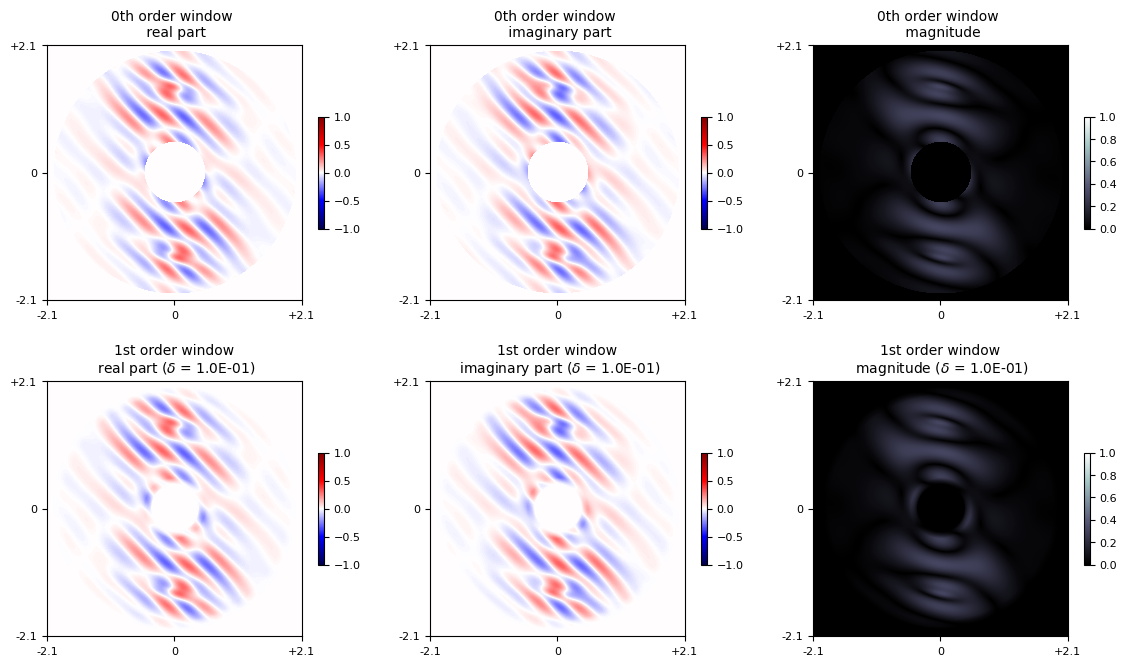

In [12]:
# frequency range
num_w = 256
w_max = DC_lo.r + 0.1
wmsh = np.meshgrid(np.linspace(-w_max, +w_max, num_w), np.linspace(-w_max, +w_max, num_w))
w = np.vstack([ wmsh[0].ravel(), wmsh[1].ravel() ]).T

# plot
plt.figure(figsize=(14, 8))
# 0th order window
mS.domain.window = 'zeroth_order'
mw_w = mS.eval_windowed(np.eye(mS.size), w)
plt.subplot(2, 3, 1)
plt.imshow(mw_w.reshape((num_w, num_w)).real, vmin=-1.0, vmax=1.0, cmap='seismic', origin='lower')
plt.xticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=8)
plt.yticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=8)
cb = plt.colorbar(shrink=0.4)
cb.ax.tick_params(labelsize=8)
plt.title('0th order window \n real part', fontsize=10)
plt.subplot(2, 3, 2)
plt.imshow(mw_w.reshape((num_w, num_w)).imag, vmin=-1.0, vmax=1.0, cmap='seismic', origin='lower')
plt.xticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=8)
plt.yticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=8)
cb = plt.colorbar(shrink=0.4)
cb.ax.tick_params(labelsize=8)
plt.title('0th order window \n imaginary part', fontsize=10)
plt.subplot(2, 3, 3)
plt.imshow(np.abs(mw_w).reshape((num_w, num_w)), vmin=0.0, vmax=1.0, cmap='bone', origin='lower')
plt.xticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=8)
plt.yticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=8)
cb = plt.colorbar(shrink=0.4)
cb.ax.tick_params(labelsize=8)
plt.title('0th order window \n magnitude', fontsize=10)
# 1st order window
mS.domain.window = 'first_order'
mS.domain.delta = 1E-1
mw_w = mS.eval_windowed(np.eye(mS.size), w)
plt.subplot(2, 3, 4)
plt.imshow(mw_w.reshape((num_w, num_w)).real, vmin=-1.0, vmax=1.0, cmap='seismic', origin='lower')
plt.xticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=8)
plt.yticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=8)
cb = plt.colorbar(shrink=0.4)
cb.ax.tick_params(labelsize=8)
plt.title(f'1st order window\n real part ($\\delta$ = {mS.domain.delta:.1E})', fontsize=10)
plt.subplot(2, 3, 5)
plt.imshow(mw_w.reshape((num_w, num_w)).imag, vmin=-1.0, vmax=1.0, cmap='seismic', origin='lower')
plt.xticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=8)
plt.yticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=8)
cb = plt.colorbar(shrink=0.4)
cb.ax.tick_params(labelsize=8)
plt.title(f'1st order window\n imaginary part ($\\delta$ = {mS.domain.delta:.1E})', fontsize=10)
plt.subplot(2, 3, 6)
plt.imshow(np.abs(mw_w).reshape((num_w, num_w)), vmin=0.0, vmax=1.0, cmap='bone', origin='lower')
plt.xticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=8)
plt.yticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=8)
cb = plt.colorbar(shrink=0.4)
cb.ax.tick_params(labelsize=8)
plt.title(f'1st order window\n magnitude ($\\delta$ = {mS.domain.delta:.1E})', fontsize=10)
plt.show()

## Optimal multiplier

To compute the optimal multiplier we import ``FixedPointIteration`` from ``objects.solver`` and ``ProjSchattenLp`` from ``objects.projector``. 

In [13]:
from adaptiveExtrapolationInFrequency.objects.solver import FixedPointIteration
from adaptiveExtrapolationInFrequency.objects.projector import ProjSchattenLp

In [14]:
# instance of FPI
FPE = FixedPointIteration()
# set verbose = True
FPE.verbose = True

# projector
P = ProjSchattenLp(n = mS.size, p = np.inf)

In [15]:
# parameters
FPE.tG = 0.15
FPE.tS = 0.75

FPE.maxitns = 100
FPE.print_every = 10
FPE.num_nodes_max = 50000
FPE.num_nodes_factor = 1.05

In [16]:
Sopt = FPE.solve(mS, P)

 itn      | obj(m)     | |x|       | |dx|      | nq     
        1 | +3.599E-03 | 2.236E+01 | 2.232E+01 |   1050
       10 | +6.744E-03 | 1.314E-02 | 1.251E-03 |   1628
       20 | +6.604E-03 | 1.229E-02 | 3.956E-04 |   2653
       30 | +6.627E-03 | 1.229E-02 | 3.264E-04 |   4321
       40 | +6.740E-03 | 1.226E-02 | 2.131E-04 |   7039
       50 | +6.646E-03 | 1.217E-02 | 1.900E-04 |  11467
       60 | +6.604E-03 | 1.215E-02 | 1.573E-04 |  18679
       70 | +6.682E-03 | 1.220E-02 | 1.170E-04 |  30426
       80 | +6.676E-03 | 1.221E-02 | 6.962E-05 |  49561
 itn      | obj(m)     | |x|       | |dx|      | nq     
       90 | +6.650E-03 | 1.222E-02 | 8.444E-05 |  50000
      100 | +6.647E-03 | 1.222E-02 | 8.673E-05 |  50000


Plot performance metrics.

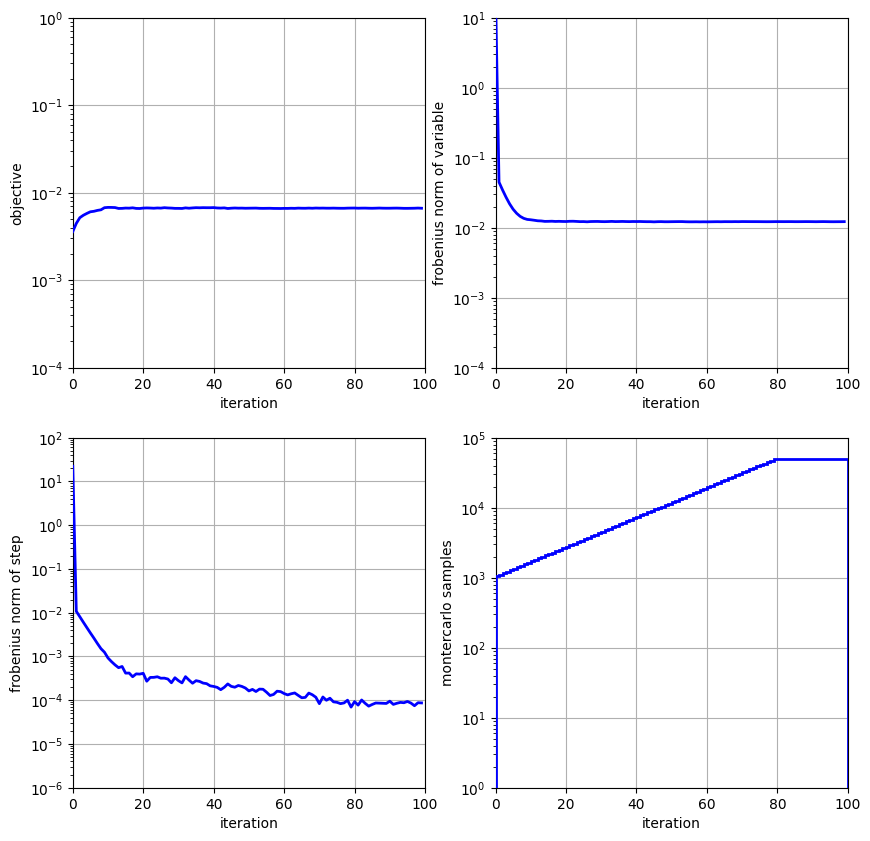

In [17]:
# plot
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(range(FPE.log['itns']), FPE.log['obj_x'], color='b', linewidth=2, zorder=5)
plt.yscale('log')
plt.ylabel('objective')
plt.ylim([ 1E-4, 1E0 ])
plt.xlabel('iteration')
plt.xlim([ 0, FPE.log['itns'] ])
plt.grid('minor')
plt.subplot(2, 2, 2)
plt.plot(range(FPE.log['itns']), FPE.log['x_nrm'], color='b', linewidth=2, zorder=5)
plt.yscale('log')
plt.ylabel('frobenius norm of variable')
plt.ylim([ 1E-4, 1E1 ])
plt.xlabel('iteration')
plt.xlim([ 0, FPE.log['itns'] ])
plt.grid('minor')
plt.subplot(2, 2, 3)
plt.plot(range(FPE.log['itns']), FPE.log['dx_nrm'], color='b', linewidth=2, zorder=5)
plt.yscale('log')
plt.ylabel('frobenius norm of step')
plt.ylim([ 1E-6, 1E2 ])
plt.xlabel('iteration')
plt.xlim([ 0, FPE.log['itns'] ])
plt.grid('minor')
plt.subplot(2, 2, 4)
plt.stairs(FPE.log['num_nodes'], range(FPE.log['itns'] + 1), color='b', linewidth=2, zorder=5)
plt.yscale('log')
plt.ylabel('montercarlo samples')
plt.ylim([ 1E0, 1E5 ])
plt.xlabel('iteration')
plt.xlim([ 0, FPE.log['itns'] ])
plt.grid('minor')
plt.show()

# figures for paper ------------------------------------------------------------------------------------------
# - objective function
plt.ioff()
plt.figure(figsize=(7, 7))
plt.plot(range(FPE.log['itns']), FPE.log['obj_x'], color='b', linewidth=2, zorder=5)
plt.yscale('log')
plt.ylabel('objective', fontsize=14)
plt.ylim([ 1E-4, 1E0 ])
plt.xlabel('iteration', fontsize=14)
plt.xlim([ 0, FPE.log['itns'] ])
plt.grid('minor')
savefig('FPE_OBJ', data_digit)
plt.close()
# - norm of variable
plt.ioff()
plt.figure(figsize=(7, 7))
plt.plot(range(FPE.log['itns']), FPE.log['x_nrm'], color='b', linewidth=2, zorder=5)
plt.yscale('log')
plt.ylabel('norm of variable', fontsize=14)
plt.ylim([ 1E-4, 1E1 ])
plt.xlabel('iteration', fontsize=14)
plt.xlim([ 0, FPE.log['itns'] ])
plt.grid('minor')
savefig('FPE_XNRM', data_digit)
plt.close()
# - step
plt.ioff()
plt.figure(figsize=(7, 7))
plt.plot(range(FPE.log['itns']), FPE.log['dx_nrm'], color='b', linewidth=2, zorder=5)
plt.yscale('log')
plt.ylabel('stepsize', fontsize=14)
plt.ylim([ 1E-6, 1E2 ])
plt.xlabel('iteration', fontsize=14)
plt.xlim([ 0, FPE.log['itns'] ])
plt.grid('minor')
savefig('FPE_DXNRM', data_digit)
plt.close()
# - step
plt.ioff()
plt.figure(figsize=(7, 7))
plt.stairs(FPE.log['num_nodes'], range(FPE.log['itns'] + 1), color='b', linewidth=2, zorder=5)
plt.yscale('log')
plt.ylabel('montercarlo samples', fontsize=14)
plt.ylim([ 1E0, 1E5 ])
plt.xlabel('iteration', fontsize=14)
plt.xlim([ 0, FPE.log['itns'] ])
plt.grid('minor')
savefig('FPE_NNODES', data_digit)
plt.close()

Plot the optimal multiplier.

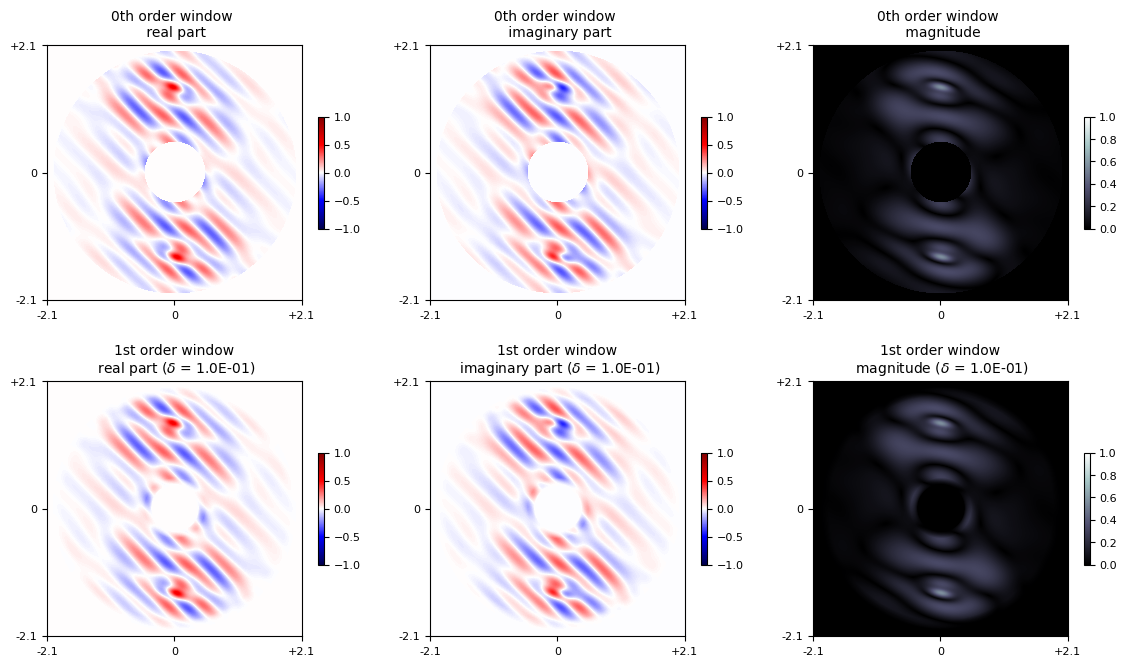

In [18]:
# plot
plt.figure(figsize=(14, 8))
# zeroth-order window
mS.domain.window = 'zeroth_order'
mw_w = mS.eval_windowed(Sopt, w)
plt.subplot(2, 3, 1)
plt.imshow(mw_w.reshape((num_w, num_w)).real, vmin=-1.0, vmax=1.0, cmap='seismic', origin='lower')
plt.xticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=8)
plt.yticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=8)
cb = plt.colorbar(shrink=0.4)
cb.ax.tick_params(labelsize=8)
plt.title('0th order window \n real part', fontsize=10)
plt.subplot(2, 3, 2)
plt.imshow(mw_w.reshape((num_w, num_w)).imag, vmin=-1.0, vmax=1.0, cmap='seismic', origin='lower')
plt.xticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=8)
plt.yticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=8)
cb = plt.colorbar(shrink=0.4)
cb.ax.tick_params(labelsize=8)
plt.title('0th order window \n imaginary part', fontsize=10)
plt.subplot(2, 3, 3)
plt.imshow(np.abs(mw_w).reshape((num_w, num_w)), vmin=0.0, vmax=1.0, cmap='bone', origin='lower')
plt.xticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=8)
plt.yticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=8)
cb = plt.colorbar(shrink=0.4)
cb.ax.tick_params(labelsize=8)
plt.title('0th order window \n magnitude', fontsize=10)
# first-order window
mS.domain.window = 'first_order'
mS.domain.delta = 1E-1
mw_w = mS.eval_windowed(Sopt, w)
plt.subplot(2, 3, 4)
plt.imshow(mw_w.reshape((num_w, num_w)).real, vmin=-1.0, vmax=1.0, cmap='seismic', origin='lower')
plt.xticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=8)
plt.yticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=8)
cb = plt.colorbar(shrink=0.4)
cb.ax.tick_params(labelsize=8)
plt.title(f'1st order window\n real part ($\\delta$ = {mS.domain.delta:.1E})', fontsize=10)
plt.subplot(2, 3, 5)
plt.imshow(mw_w.reshape((num_w, num_w)).imag, vmin=-1.0, vmax=1.0, cmap='seismic', origin='lower')
plt.xticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=8)
plt.yticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=8)
cb = plt.colorbar(shrink=0.4)
cb.ax.tick_params(labelsize=8)
plt.title(f'1st order window\n imaginary part ($\\delta$ = {mS.domain.delta:.1E})', fontsize=10)
plt.subplot(2, 3, 6)
plt.imshow(np.abs(mw_w).reshape((num_w, num_w)), vmin=0.0, vmax=1.0, cmap='bone', origin='lower')
plt.xticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=8)
plt.yticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=8)
cb = plt.colorbar(shrink=0.4)
cb.ax.tick_params(labelsize=8)
plt.title(f'1st order window\n magnitude ($\\delta$ = {mS.domain.delta:.1E})', fontsize=10)
plt.show()

# figures for paper ------------------------------------------------------------------------------------------
plt.ioff()
plt.figure(figsize=(12, 7))
# zeroth-order window
mS.domain.window = 'zeroth_order'
mw_w = mS.eval_windowed(Sopt, w)
plt.subplot(2, 3, 1)
plt.imshow(mw_w.reshape((num_w, num_w)).real, vmin=-1.0, vmax=1.0, cmap='seismic', origin='lower')
plt.xticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=12)
plt.yticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=12)
cb = plt.colorbar(shrink=0.4)
cb.ax.tick_params(labelsize=10)
plt.title('real part', fontsize=14)
plt.subplot(2, 3, 2)
plt.imshow(mw_w.reshape((num_w, num_w)).imag, vmin=-1.0, vmax=1.0, cmap='seismic', origin='lower')
plt.xticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=12)
plt.yticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=12)
cb = plt.colorbar(shrink=0.4)
cb.ax.tick_params(labelsize=10)
plt.title('imaginary part', fontsize=14)
plt.subplot(2, 3, 3)
plt.imshow(np.abs(mw_w).reshape((num_w, num_w)), vmin=0.0, vmax=1.0, cmap='bone', origin='lower')
plt.xticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=12)
plt.yticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=12)
cb = plt.colorbar(shrink=0.4)
cb.ax.tick_params(labelsize=10)
plt.title('magnitude', fontsize=14)
savefig('MOPT', data_digit)
plt.close()

Compute and plot the optimal multiplier in the spatial domain.

In [19]:
from adaptiveExtrapolationInFrequency.routines.integrals import inverse_fourier_transform_2d_squares

In [20]:
# spatial range
num_x = 256
x_max = 5
xmsh = np.meshgrid(np.linspace(-x_max + 0.5, +x_max + 0.5, num_x), np.linspace(-x_max, +x_max, num_x))
x = np.vstack([ xmsh[0].ravel(), xmsh[1].ravel() ], dtype=float).T
# coefficients for interpolation
M = 72 * np.ones((2,), dtype=int)
# with no smoothing
mS.domain.window = 'zeroth_order'
u_x = inverse_fourier_transform_2d_squares(lambda w : mS.eval_windowed(Sopt, w), x, 0.5 * mS.domain.width, M).reshape((num_x, num_x))
u_x_max = np.abs(u_x).max()
# with smoothing
mS.domain.window = 'first_order'
mS.domain.delta = 2.5E-1
us_x = inverse_fourier_transform_2d_squares(lambda w : mS.eval_windowed(Sopt, w), x, 0.5 * mS.domain.width, M).reshape((num_x, num_x))
us_x_max = np.abs(us_x).max()

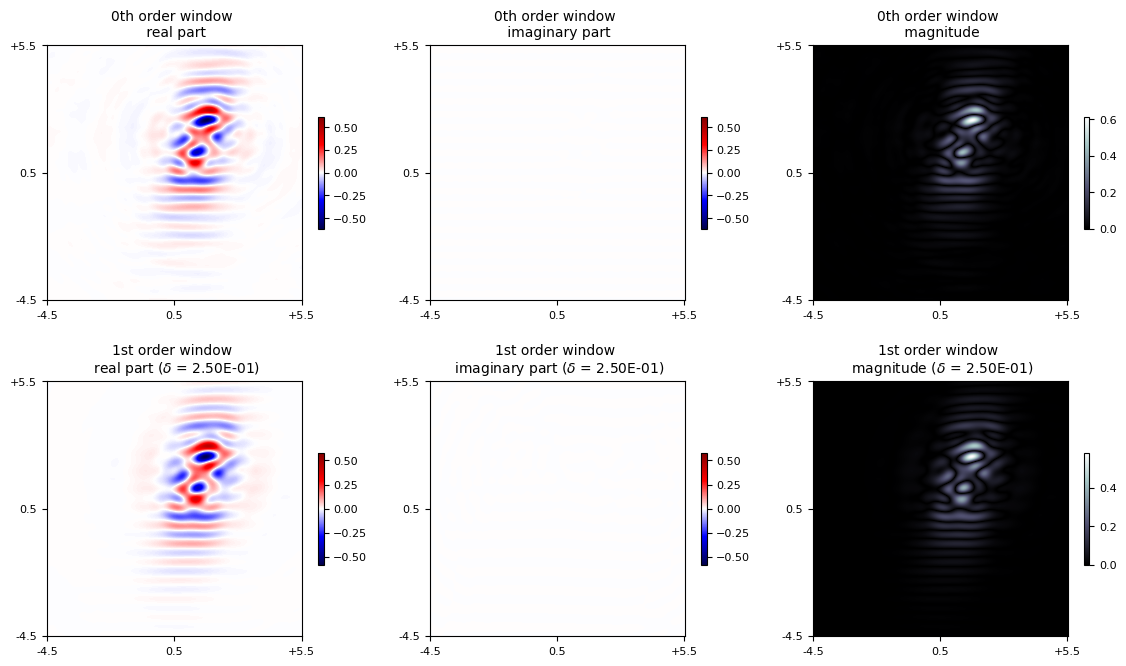

In [21]:
# plot
plt.figure(figsize=(14, 8))
plt.subplot(2, 3, 1)
plt.imshow(u_x.real, vmin=-u_x_max, vmax=+u_x_max, cmap='seismic', origin='lower')
plt.xticks([ 0, (num_x - 1) / 2, num_x-1 ], labels=[ f'{-x_max + 0.5:+.1f}', '0.5', f'{+x_max + 0.5:+.1f}' ], fontsize=8)
plt.yticks([ 0, (num_x - 1) / 2, num_x-1 ], labels=[ f'{-x_max + 0.5:+.1f}', '0.5', f'{+x_max + 0.5:+.1f}' ], fontsize=8)
cb = plt.colorbar(shrink=0.4)
cb.ax.tick_params(labelsize=8)
plt.title('0th order window \n real part', fontsize=10)
plt.subplot(2, 3, 2)
plt.imshow(u_x.imag, vmin=-u_x_max, vmax=+u_x_max, cmap='seismic', origin='lower')
plt.xticks([ 0, (num_x - 1) / 2, num_x-1 ], labels=[ f'{-x_max + 0.5:+.1f}', '0.5', f'{+x_max + 0.5:+.1f}' ], fontsize=8)
plt.yticks([ 0, (num_x - 1) / 2, num_x-1 ], labels=[ f'{-x_max + 0.5:+.1f}', '0.5', f'{+x_max + 0.5:+.1f}' ], fontsize=8)
cb = plt.colorbar(shrink=0.4)
cb.ax.tick_params(labelsize=8)
plt.title('0th order window \n imaginary part', fontsize=10)
plt.subplot(2, 3, 3)
plt.imshow(np.abs(u_x), vmin=0.0, vmax=u_x_max, cmap='bone', origin='lower')
plt.xticks([ 0, (num_x - 1) / 2, num_x-1 ], labels=[ f'{-x_max + 0.5:+.1f}', '0.5', f'{+x_max + 0.5:+.1f}' ], fontsize=8)
plt.yticks([ 0, (num_x - 1) / 2, num_x-1 ], labels=[ f'{-x_max + 0.5:+.1f}', '0.5', f'{+x_max + 0.5:+.1f}' ], fontsize=8)
cb = plt.colorbar(shrink=0.4)
cb.ax.tick_params(labelsize=8)
plt.title('0th order window \n magnitude', fontsize=10)
plt.subplot(2, 3, 4)
plt.imshow(us_x.real, vmin=-us_x_max, vmax=+us_x_max, cmap='seismic', origin='lower')
plt.xticks([ 0, (num_x - 1) / 2, num_x-1 ], labels=[ f'{-x_max + 0.5:+.1f}', '0.5', f'{+x_max + 0.5:+.1f}' ], fontsize=8)
plt.yticks([ 0, (num_x - 1) / 2, num_x-1 ], labels=[ f'{-x_max + 0.5:+.1f}', '0.5', f'{+x_max + 0.5:+.1f}' ], fontsize=8)
cb = plt.colorbar(shrink=0.4)
cb.ax.tick_params(labelsize=8)
plt.title(f'1st order window \n real part ($\\delta$ = {mS.domain.delta:.2E})', fontsize=10)
plt.subplot(2, 3, 5)
plt.imshow(us_x.imag, vmin=-us_x_max, vmax=+us_x_max, cmap='seismic', origin='lower')
plt.xticks([ 0, (num_x - 1) / 2, num_x-1 ], labels=[ f'{-x_max + 0.5:+.1f}', '0.5', f'{+x_max + 0.5:+.1f}' ], fontsize=8)
plt.yticks([ 0, (num_x - 1) / 2, num_x-1 ], labels=[ f'{-x_max + 0.5:+.1f}', '0.5', f'{+x_max + 0.5:+.1f}' ], fontsize=8)
cb = plt.colorbar(shrink=0.4)
cb.ax.tick_params(labelsize=8)
plt.title(f'1st order window \n imaginary part ($\\delta$ = {mS.domain.delta:.2E})', fontsize=10)
plt.subplot(2, 3, 6)
plt.imshow(np.abs(us_x), vmin=0.0, vmax=us_x_max, cmap='bone', origin='lower')
plt.xticks([ 0, (num_x - 1) / 2, num_x-1 ], labels=[ f'{-x_max + 0.5:+.1f}', '0.5', f'{+x_max + 0.5:+.1f}' ], fontsize=8)
plt.yticks([ 0, (num_x - 1) / 2, num_x-1 ], labels=[ f'{-x_max + 0.5:+.1f}', '0.5', f'{+x_max + 0.5:+.1f}' ], fontsize=8)
cb = plt.colorbar(shrink=0.4)
cb.ax.tick_params(labelsize=8)
plt.title(f'1st order window \n magnitude ($\\delta$ = {mS.domain.delta:.2E})', fontsize=10)
plt.show()

# figures for paper ------------------------------------------------------------------------------------------
plt.ioff()
plt.figure(figsize=(12, 7))
plt.subplot(1, 3, 1)
plt.imshow(u_x.real, vmin=-u_x_max, vmax=+u_x_max, cmap='seismic', origin='lower')
plt.xticks([ 0, (num_x - 1) / 2, num_x-1 ], labels=[ f'{-x_max + 0.5:+.1f}', '0.5', f'{+x_max + 0.5:+.1f}' ], fontsize=12)
plt.yticks([ 0, (num_x - 1) / 2, num_x-1 ], labels=[ f'{-x_max + 0.5:+.1f}', '0.5', f'{+x_max + 0.5:+.1f}' ], fontsize=12)
cb = plt.colorbar(shrink=0.2)
cb.ax.tick_params(labelsize=10)
plt.title('real part', fontsize=14)
plt.subplot(1, 3, 2)
plt.imshow(u_x.imag, vmin=-u_x_max, vmax=+u_x_max, cmap='seismic', origin='lower')
plt.xticks([ 0, (num_x - 1) / 2, num_x-1 ], labels=[ f'{-x_max + 0.5:+.1f}', '0.5', f'{+x_max + 0.5:+.1f}' ], fontsize=12)
plt.yticks([ 0, (num_x - 1) / 2, num_x-1 ], labels=[ f'{-x_max + 0.5:+.1f}', '0.5', f'{+x_max + 0.5:+.1f}' ], fontsize=12)
cb = plt.colorbar(shrink=0.2)
cb.ax.tick_params(labelsize=10)
plt.title('imaginary part', fontsize=14)
plt.subplot(1, 3, 3)
plt.imshow(np.abs(u_x), vmin=0.0, vmax=u_x_max, cmap='bone', origin='lower')
plt.xticks([ 0, (num_x - 1) / 2, num_x-1 ], labels=[ f'{-x_max + 0.5:+.1f}', '0.5', f'{+x_max + 0.5:+.1f}' ], fontsize=12)
plt.yticks([ 0, (num_x - 1) / 2, num_x-1 ], labels=[ f'{-x_max + 0.5:+.1f}', '0.5', f'{+x_max + 0.5:+.1f}' ], fontsize=12)
cb = plt.colorbar(shrink=0.2)
cb.ax.tick_params(labelsize=10)
plt.title('magnitude', fontsize=14)
savefig('MOPT_X', data_digit)
plt.close()

## Worst and best cases

Compute the best and worst cases from the optimal multiplier. Since the collecion may be linearly dependent, we restrict the worst case to lie in the complement of the nullspace. 

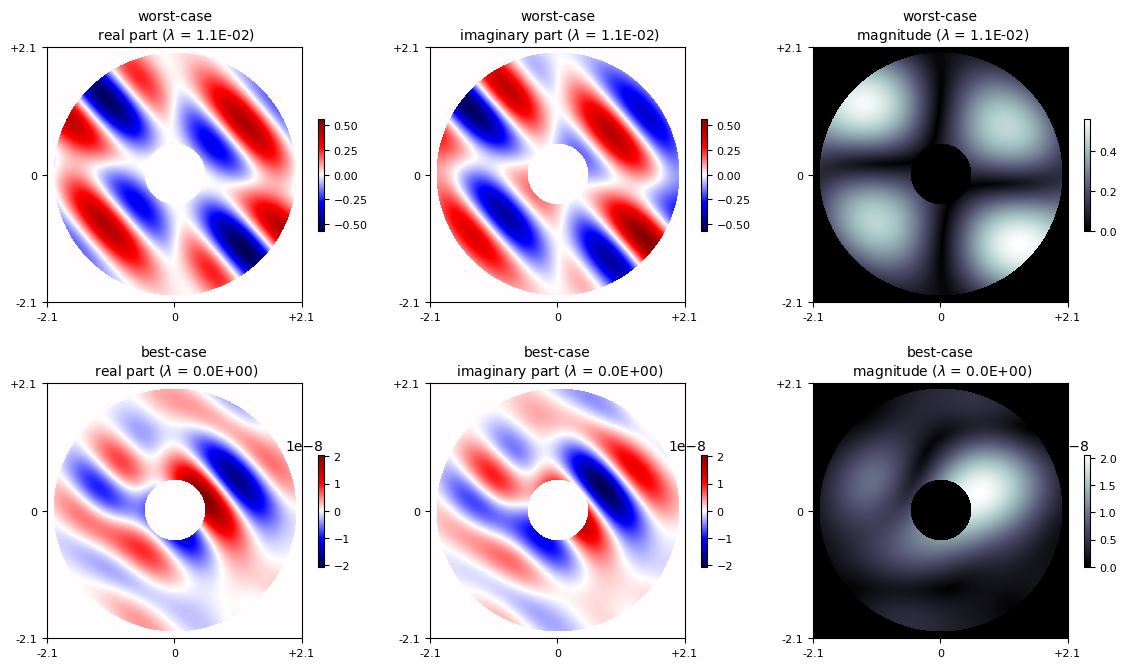

In [22]:
# 'mc' for MonteCarlo, 'quad' for a quadrature rule
mS.quadrule = 'mc'
# gram matrix of residuals
G = mS.eval_residual_gram(Sopt, 10000)
# eigendecomposition
[ D, V ] = np.linalg.eigh(G)
D = np.maximum(0.0, D)
# worst-case
f_wc = (np.conj(V).T[-1] @ mS.eval_function(w)).reshape((num_w, num_w))
f_wc_max = np.abs(f_wc).max()
# best-case
bc_index = 0 #
f_bc = (np.conj(V).T[bc_index] @ mS.eval_function(w)).reshape((num_w, num_w))
f_bc_max = np.abs(f_bc).max()
# window
mS.domain.window = 'zeroth_order'
h_w = mS.domain.eval_window(w).reshape((num_w, num_w))

plt.figure(figsize=(14, 8))
plt.subplot(2, 3, 1)
plt.imshow((h_w * f_wc).real, vmin=-f_wc_max, vmax=+f_wc_max, cmap='seismic', origin='lower')
plt.xticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}'], fontsize=8)
plt.yticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}'], fontsize=8)
cb = plt.colorbar(shrink=0.4)
cb.ax.tick_params(labelsize=8)
plt.title(f'worst-case\n real part ($\\lambda$ = {D[-1]:.1E})', fontsize=10)
plt.subplot(2, 3, 2)
plt.imshow((h_w * f_wc).imag, vmin=-f_wc_max, vmax=+f_wc_max, cmap='seismic', origin='lower')
plt.xticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}'], fontsize=8)
plt.yticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}'], fontsize=8)
cb = plt.colorbar(shrink=0.4)
cb.ax.tick_params(labelsize=8)
plt.title(f'worst-case\n imaginary part ($\\lambda$ = {D[-1]:.1E})', fontsize=10)
plt.subplot(2, 3, 3)
plt.imshow(np.abs(h_w * f_wc), vmin=0.0, vmax=f_wc_max, cmap='bone', origin='lower')
plt.xticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}'], fontsize=8)
plt.yticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}'], fontsize=8)
cb = plt.colorbar(shrink=0.4)
cb.ax.tick_params(labelsize=8)
plt.title(f'worst-case\n magnitude ($\\lambda$ = {D[-1]:.1E})', fontsize=10)
plt.subplot(2, 3, 4)
plt.imshow((h_w * f_bc).real, vmin=-f_bc_max, vmax=+f_bc_max, cmap='seismic', origin='lower')
plt.xticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}'], fontsize=8)
plt.yticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}'], fontsize=8)
cb = plt.colorbar(shrink=0.4)
cb.ax.tick_params(labelsize=8)
plt.title(f'best-case\n real part ($\\lambda$ = {D[bc_index]:.1E})', fontsize=10)
plt.subplot(2, 3, 5)
plt.imshow((h_w * f_bc).imag, vmin=-f_bc_max, vmax=+f_bc_max, cmap='seismic', origin='lower')
plt.xticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}'], fontsize=8)
plt.yticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}'], fontsize=8)
cb = plt.colorbar(shrink=0.4)
cb.ax.tick_params(labelsize=8)
plt.title(f'best-case\n imaginary part ($\\lambda$ = {D[bc_index]:.1E})', fontsize=10)
plt.subplot(2, 3, 6)
plt.imshow(np.abs(h_w * f_bc), vmin=0.0, vmax=f_bc_max, cmap='bone', origin='lower')
plt.xticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}'], fontsize=8)
plt.yticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}'], fontsize=8)
cb = plt.colorbar(shrink=0.4)
cb.ax.tick_params(labelsize=8)
plt.title(f'best-case\n magnitude ($\\lambda$ = {D[bc_index]:.1E})', fontsize=10)
plt.show()

# figures for paper ------------------------------------------------------------------------------------------
plt.ioff()
plt.figure(figsize=(12, 7))
# zeroth-order window
mS.domain.window = 'zeroth_order'
mw_w = mS.eval_windowed(Sopt, w)
plt.subplot(2, 3, 1)
plt.imshow((h_w * f_wc).real, vmin=-f_wc_max, vmax=+f_wc_max, cmap='seismic', origin='lower')
plt.xticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=12)
plt.yticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=12)
cb = plt.colorbar(shrink=0.4)
cb.ax.tick_params(labelsize=10)
plt.title('real part', fontsize=14)
plt.subplot(2, 3, 2)
plt.imshow((h_w * f_wc).imag, vmin=-f_wc_max, vmax=+f_wc_max, cmap='seismic', origin='lower')
plt.xticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=12)
plt.yticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=12)
cb = plt.colorbar(shrink=0.4)
cb.ax.tick_params(labelsize=10)
plt.title('imaginary part', fontsize=14)
plt.subplot(2, 3, 3)
plt.imshow(np.abs(h_w * f_wc).reshape((num_w, num_w)), vmin=0.0, vmax=f_wc_max, cmap='bone', origin='lower')
plt.xticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=12)
plt.yticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=12)
cb = plt.colorbar(shrink=0.4)
cb.ax.tick_params(labelsize=10)
plt.title('magnitude', fontsize=14)
savefig('MOPT_WC', data_digit)
plt.close()

plt.ioff()
plt.figure(figsize=(12, 7))
# zeroth-order window
mS.domain.window = 'zeroth_order'
mw_w = mS.eval_windowed(Sopt, w)
plt.subplot(2, 3, 1)
plt.imshow((h_w * f_bc).real, vmin=-f_bc_max, vmax=+f_bc_max, cmap='seismic', origin='lower')
plt.xticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=12)
plt.yticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=12)
cb = plt.colorbar(shrink=0.4)
cb.ax.tick_params(labelsize=10)
plt.title('real part', fontsize=14)
plt.subplot(2, 3, 2)
plt.imshow((h_w * f_bc).imag, vmin=-f_bc_max, vmax=+f_bc_max, cmap='seismic', origin='lower')
plt.xticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=12)
plt.yticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=12)
cb = plt.colorbar(shrink=0.4)
cb.ax.tick_params(labelsize=10)
plt.title('imaginary part', fontsize=14)
plt.subplot(2, 3, 3)
plt.imshow(np.abs(h_w * f_bc).reshape((num_w, num_w)), vmin=0.0, vmax=f_bc_max, cmap='bone', origin='lower')
plt.xticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=12)
plt.yticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=12)
cb = plt.colorbar(shrink=0.4)
cb.ax.tick_params(labelsize=10)
plt.title('magnitude', fontsize=14)
savefig('MOPT_BC', data_digit)
plt.close()

Plot the eigenvalues of $\Sigma^{\star}$.

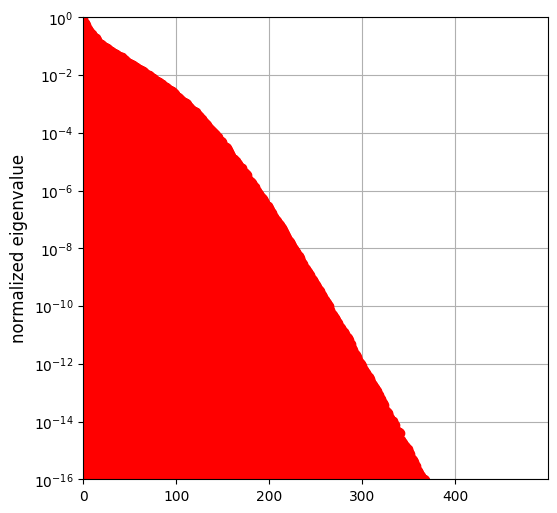

In [23]:
# plot
plt.figure(figsize=(6, 6))
plt.stem(range(D.size), D[::-1]/D[-1], markerfmt='ro', linefmt='r-', basefmt='r-')
plt.xlim([ -0.5, D.size - 0.5 ])
plt.ylim([ 1E-16, 1E0 ])
plt.ylabel('normalized eigenvalue', fontsize=12)
plt.yscale('log')
plt.grid('both')
plt.show()

Plot the images associated to the worst and best cases.

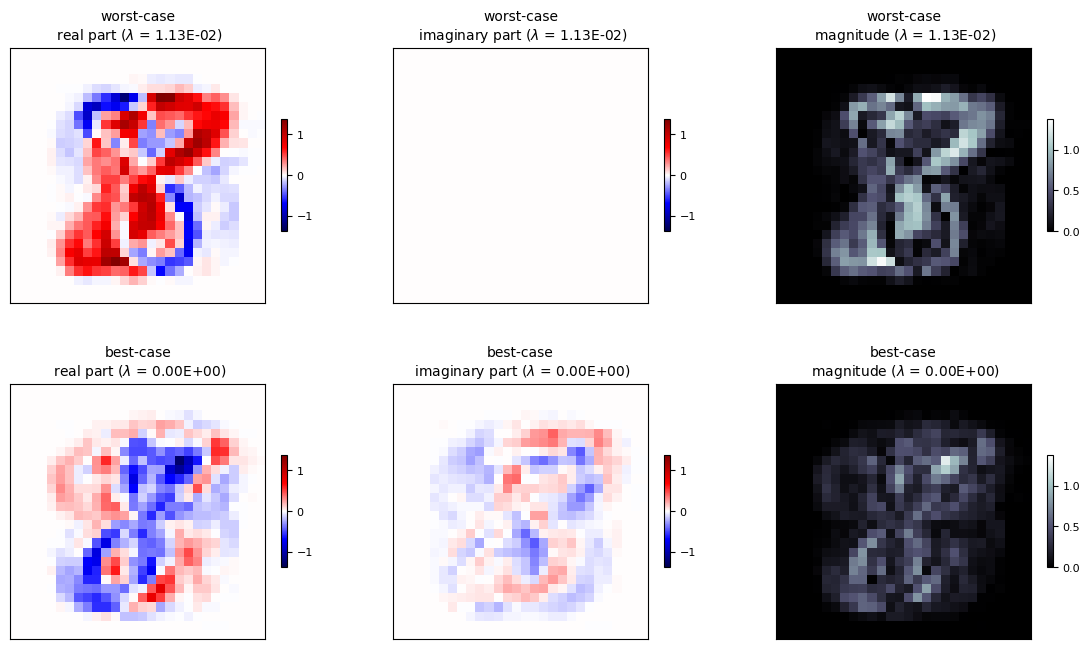

In [24]:
X_wc = (V[0, :].T @ A).reshape(N)
X_bc = (V[1, :].T @ A).reshape(N)

x_wc_max = np.abs(X_wc).max()
x_bc_max = np.abs(X_wc).max()

plt.figure(figsize=(14, 8))
plt.subplot(2, 3, 1)
plt.imshow(X_wc.real, vmin=-x_wc_max, vmax=+x_wc_max, origin='lower', cmap='seismic')
plt.xticks([])
plt.yticks([])
plt.title(f'worst-case\n real part ($\\lambda$ = {D[-1]:.2E})', fontsize=10)
cb = plt.colorbar(shrink=0.4)
cb.ax.tick_params(labelsize=8)
plt.subplot(2, 3, 2)
plt.imshow(X_wc.imag, vmin=-x_wc_max, vmax=+x_wc_max, origin='lower', cmap='seismic')
plt.xticks([])
plt.yticks([])
plt.title(f'worst-case\n imaginary part ($\\lambda$ = {D[-1]:.2E})', fontsize=10)
cb = plt.colorbar(shrink=0.4)
cb.ax.tick_params(labelsize=8)
plt.subplot(2, 3, 3)
plt.imshow(np.abs(X_wc), vmin=0.0, vmax=x_wc_max, origin='lower', cmap='bone')
plt.xticks([])
plt.yticks([])
plt.title(f'worst-case\n magnitude ($\\lambda$ = {D[-1]:.2E})', fontsize=10)
cb = plt.colorbar(shrink=0.4)
cb.ax.tick_params(labelsize=8)
plt.subplot(2, 3, 4)
plt.imshow(X_bc.real, vmin=-x_bc_max, vmax=+x_bc_max, origin='lower', cmap='seismic')
plt.xticks([])
plt.yticks([])
plt.title(f'best-case\n real part ($\\lambda$ = {D[bc_index]:.2E})', fontsize=10)
cb = plt.colorbar(shrink=0.4)
cb.ax.tick_params(labelsize=8)
plt.subplot(2, 3, 5)
plt.imshow(X_bc.imag, vmin=-x_bc_max, vmax=+x_bc_max, origin='lower', cmap='seismic')
plt.xticks([])
plt.yticks([])
plt.title(f'best-case\n imaginary part ($\\lambda$ = {D[bc_index]:.2E})', fontsize=10)
cb = plt.colorbar(shrink=0.4)
cb.ax.tick_params(labelsize=8)
plt.subplot(2, 3, 6)
plt.imshow(np.abs(X_bc), vmin=0.0, vmax=x_bc_max, origin='lower', cmap='bone')
plt.xticks([])
plt.yticks([])
plt.title(f'best-case\n magnitude ($\\lambda$ = {D[bc_index]:.2E})', fontsize=10)
cb = plt.colorbar(shrink=0.4)
cb.ax.tick_params(labelsize=8)
plt.show()

# figures for paper ------------------------------------------------------------------------------------------
plt.ioff()
plt.figure(figsize=(12, 7))
plt.subplot(1, 3, 1)
plt.imshow(X_wc.real, vmin=-x_wc_max, vmax=+x_wc_max, origin='lower', cmap='seismic')
plt.xticks([])
plt.yticks([])
plt.title(f'real part', fontsize=14)
cb = plt.colorbar(shrink=0.2)
cb.ax.tick_params(labelsize=10)
plt.subplot(1, 3, 2)
plt.imshow(X_wc.imag, vmin=-x_wc_max, vmax=+x_wc_max, origin='lower', cmap='seismic')
plt.xticks([])
plt.yticks([])
plt.title(f'imaginary part', fontsize=14)
cb = plt.colorbar(shrink=0.2)
cb.ax.tick_params(labelsize=10)
plt.subplot(1, 3, 3)
plt.imshow(np.abs(X_wc), vmin=0.0, vmax=x_wc_max, origin='lower', cmap='bone')
plt.xticks([])
plt.yticks([])
plt.title(f'magnitude', fontsize=14)
cb = plt.colorbar(shrink=0.2)
cb.ax.tick_params(labelsize=10)
savefig('MOPT_WC_X', data_digit)
plt.close()

plt.ioff()
plt.figure(figsize=(12, 7))
plt.subplot(1, 3, 1)
plt.imshow(X_bc.real, vmin=-x_bc_max, vmax=+x_bc_max, origin='lower', cmap='seismic')
plt.xticks([])
plt.yticks([])
plt.title(f'real part', fontsize=14)
cb = plt.colorbar(shrink=0.2)
cb.ax.tick_params(labelsize=10)
plt.subplot(1, 3, 2)
plt.imshow(X_bc.imag, vmin=-x_bc_max, vmax=+x_bc_max, origin='lower', cmap='seismic')
plt.xticks([])
plt.yticks([])
plt.title(f'imaginary part', fontsize=14)
cb = plt.colorbar(shrink=0.2)
cb.ax.tick_params(labelsize=10)
plt.subplot(1, 3, 3)
plt.imshow(np.abs(X_bc), vmin=0.0, vmax=x_bc_max, origin='lower', cmap='bone')
plt.xticks([])
plt.yticks([])
plt.title(f'magnitude', fontsize=14)
cb = plt.colorbar(shrink=0.2)
cb.ax.tick_params(labelsize=10)
savefig('MOPT_BC_X', data_digit)
plt.close()

## Extrapolation in frequency

Perform frequency extrapolation.

In [25]:
# number of images
num_imgs = 5
# discretization parameter
M = ( 64, 64 )
# selected images
# random
#img_index = np.random.randint(0, num_data, num_imgs)
# deterministic / for reproducibility
img_index = [ I for I in range(num_imgs) ]

Show extrapolation in the frequency domain.

In [26]:
# frequency range
num_w = 256
w_max = DC_hi.r + 0.1 
wmsh = np.meshgrid(np.linspace(-w_max, +w_max, num_w), np.linspace(-w_max, +w_max, num_w))
w = np.vstack([ wmsh[0].ravel(), wmsh[1].ravel() ]).T

In [27]:
# low- and high-frequency
X_los = np.array([ (DC_lo.eval_window(w) * f(w)[I]).reshape((num_w, num_w)) for I in img_index ])
X_his = np.array([ (DC_hi.eval_window(w) * f(w)[I]).reshape((num_w, num_w)) for I in img_index ])

In [28]:
# extrapolation in frequency
X_exts = X_los + np.array([ (DC_hi.eval_window(w) * (1 - DC_lo.eval_window(w)) * mS.eval_windowed(Sopt, w/alpha) * f(w/alpha)[I]).reshape((num_w, num_w)) for I in img_index ])

Plot the results.

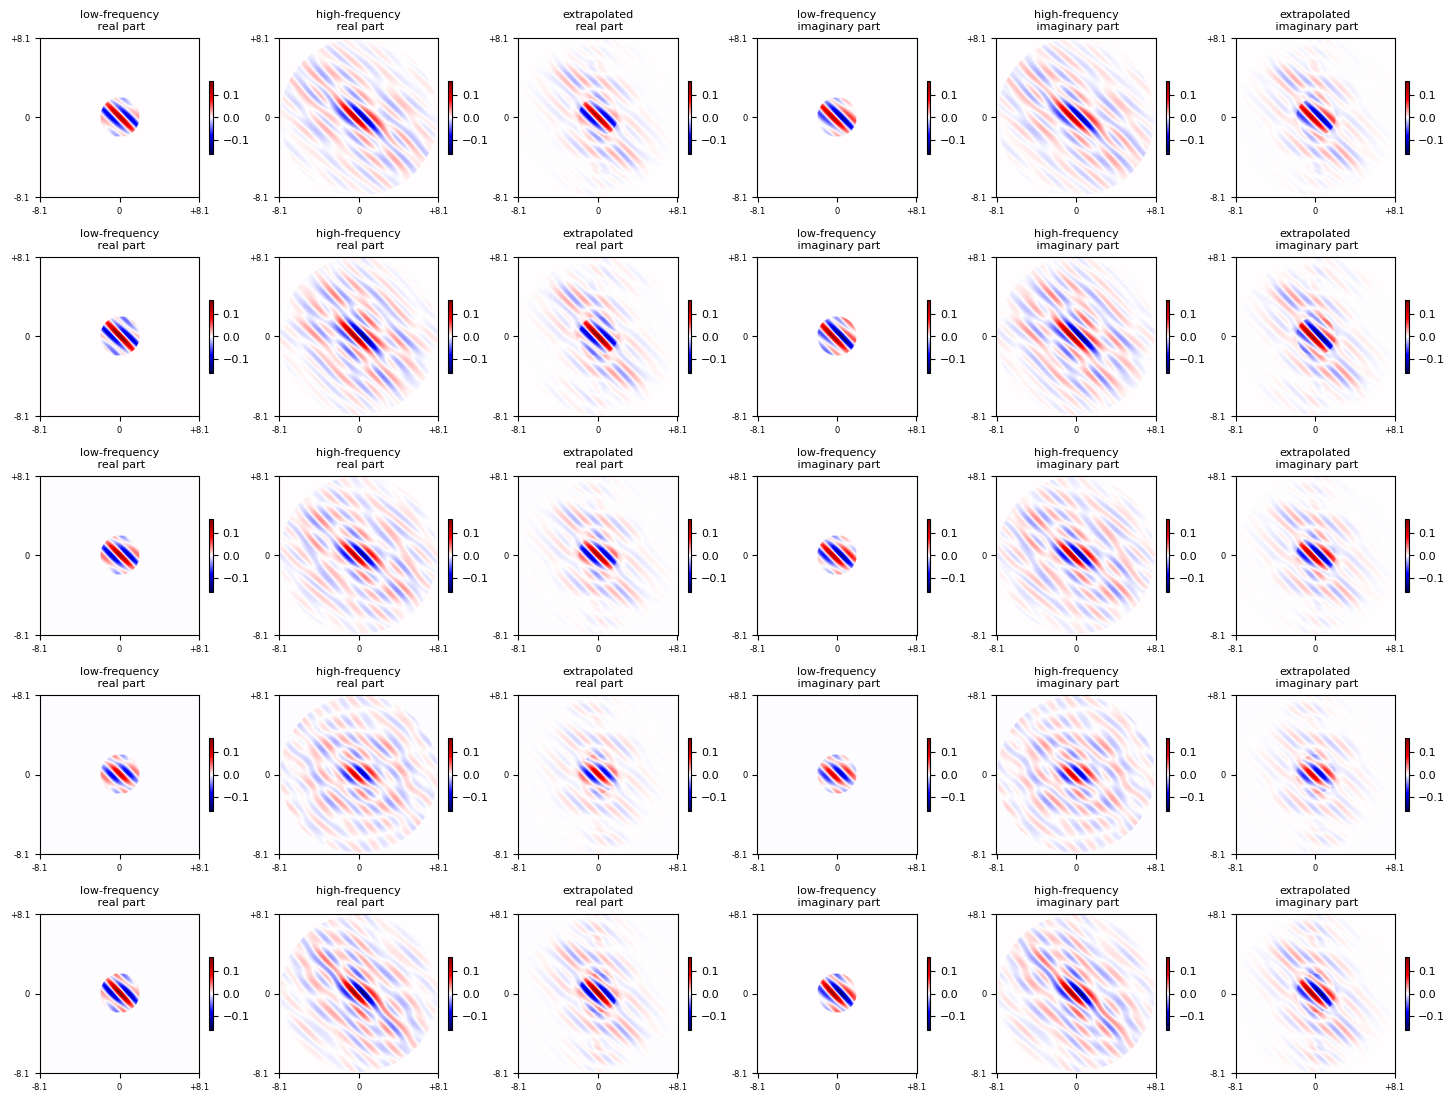

In [29]:
x_max = np.max([ np.abs(X_los).max(), np.abs(X_his).max(), np.abs(X_exts).max() ])

plt.figure(figsize=(18, 2.75 * num_imgs))
for I, (X_lo, X_hi, X_ext) in enumerate(zip(X_los, X_his, X_exts)):
  plt.subplot(num_imgs, 6, 1 + 6 * I)
  plt.imshow(X_lo.real, vmin=-x_max, vmax=+x_max, origin='lower', cmap='seismic')
  plt.xticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=6)
  plt.yticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=6)
  plt.title(f'low-frequency\n real part', fontsize=8)
  cb = plt.colorbar(shrink=0.4)
  cb.ax.tick_params(labelsize=8)
  plt.subplot(num_imgs, 6, 2 + 6 * I)
  plt.imshow(X_hi.imag, vmin=-x_max, vmax=+x_max, origin='lower', cmap='seismic')
  plt.xticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=6)
  plt.yticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=6)
  plt.title(f'high-frequency\n real part', fontsize=8)
  cb = plt.colorbar(shrink=0.4)
  cb.ax.tick_params(labelsize=8)
  plt.subplot(num_imgs, 6, 3 + 6 * I)
  plt.imshow(X_ext.real, vmin=-x_max, vmax=+x_max, origin='lower', cmap='seismic')
  plt.xticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=6)
  plt.yticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=6)
  plt.title(f'extrapolated\n real part', fontsize=8)
  cb = plt.colorbar(shrink=0.4)
  cb.ax.tick_params(labelsize=8)

  plt.subplot(num_imgs, 6, 4 + 6 * I)
  plt.imshow(X_lo.imag, vmin=-x_max, vmax=+x_max, origin='lower', cmap='seismic')
  plt.xticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=6)
  plt.yticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=6)
  plt.title(f'low-frequency\n imaginary part', fontsize=8)
  cb = plt.colorbar(shrink=0.4)
  cb.ax.tick_params(labelsize=8)
  plt.subplot(num_imgs, 6, 5 + 6 * I)
  plt.imshow(X_hi.imag, vmin=-x_max, vmax=+x_max, origin='lower', cmap='seismic')
  plt.xticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=6)
  plt.yticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=6)
  plt.title(f'high-frequency\n imaginary part', fontsize=8)
  cb = plt.colorbar(shrink=0.4)
  cb.ax.tick_params(labelsize=8)
  plt.subplot(num_imgs, 6, 6 + 6 * I)
  plt.imshow(X_ext.imag, vmin=-x_max, vmax=+x_max, origin='lower', cmap='seismic')
  plt.xticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=6)
  plt.yticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=6)
  plt.title(f'extrapolated\n imaginary part', fontsize=8)
  cb = plt.colorbar(shrink=0.4)
  cb.ax.tick_params(labelsize=8)
plt.show()

# figures for paper ------------------------------------------------------------------------------------------
plt.ioff()
plt.figure(figsize=(12, 7))
plt.subplot(2, 3, 1)
plt.imshow(X_los[0].real, vmin=-x_max, vmax=+x_max, origin='lower', cmap='seismic')
plt.xticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=12)
plt.yticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=12)
plt.title(f'low-frequency\n real part', fontsize=14)
cb = plt.colorbar(shrink=0.4)
cb.ax.tick_params(labelsize=10)
plt.subplot(2, 3, 2)
plt.imshow(X_his[0].imag, vmin=-x_max, vmax=+x_max, origin='lower', cmap='seismic')
plt.xticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=12)
plt.yticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=12)
plt.title(f'high-frequency\n real part', fontsize=14)
cb = plt.colorbar(shrink=0.4)
cb.ax.tick_params(labelsize=10)
plt.subplot(2, 3, 3)
plt.imshow(X_exts[0].real, vmin=-x_max, vmax=+x_max, origin='lower', cmap='seismic')
plt.xticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=12)
plt.yticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=12)
plt.title(f'extrapolated\n real part', fontsize=14)
cb = plt.colorbar(shrink=0.4)
cb.ax.tick_params(labelsize=10)
plt.subplot(2, 3, 4)
plt.imshow(X_los[0].imag, vmin=-x_max, vmax=+x_max, origin='lower', cmap='seismic')
plt.xticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=12)
plt.yticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=12)
plt.title(f'low-frequency\n imaginary part', fontsize=14)
cb = plt.colorbar(shrink=0.4)
cb.ax.tick_params(labelsize=10)
plt.subplot(2, 3, 5)
plt.imshow(X_his[0].imag, vmin=-x_max, vmax=+x_max, origin='lower', cmap='seismic')
plt.xticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=12)
plt.yticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=12)
plt.title(f'high-frequency\n imaginary part', fontsize=14)
cb = plt.colorbar(shrink=0.4)
cb.ax.tick_params(labelsize=10)
plt.subplot(2, 3, 6)
plt.imshow(X_exts[0].imag, vmin=-x_max, vmax=+x_max, origin='lower', cmap='seismic')
plt.xticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=12)
plt.yticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=12)
plt.title(f'extrapolated\n imaginary part', fontsize=14)
cb = plt.colorbar(shrink=0.4)
cb.ax.tick_params(labelsize=10)
savefig('EXT_RI', data_digit)
plt.close()

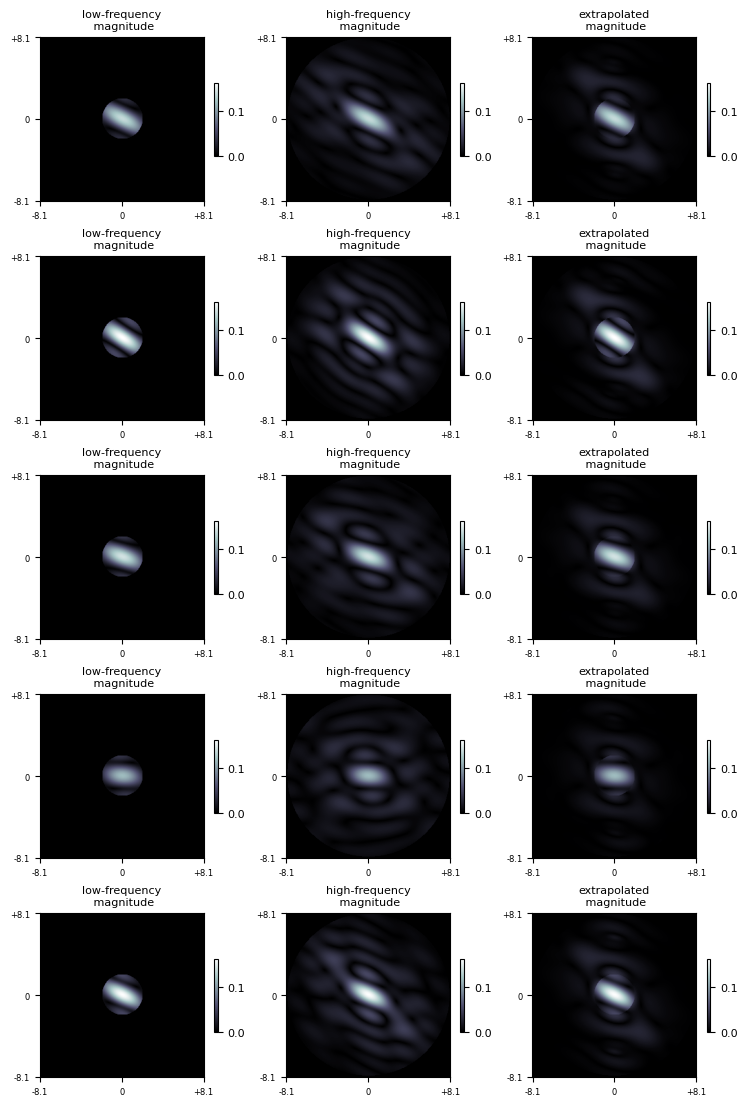

In [30]:
plt.figure(figsize=(9, 2.75 * num_imgs))
for I, (X_lo, X_hi, X_ext) in enumerate(zip(X_los, X_his, X_exts)):
  plt.subplot(num_imgs, 3, 1 + 3 * I)
  plt.imshow(np.abs(X_lo), vmin=0, vmax=+x_max, origin='lower', cmap='bone')
  plt.xticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=6)
  plt.yticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=6)
  plt.title(f'low-frequency\n magnitude', fontsize=8)
  cb = plt.colorbar(shrink=0.4)
  cb.ax.tick_params(labelsize=8)
  plt.subplot(num_imgs, 3, 2 + 3 * I)
  plt.imshow(np.abs(X_hi), vmin=0, vmax=+x_max, origin='lower', cmap='bone')
  plt.xticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=6)
  plt.yticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=6)
  plt.title(f'high-frequency\n magnitude', fontsize=8)
  cb = plt.colorbar(shrink=0.4)
  cb.ax.tick_params(labelsize=8)
  plt.subplot(num_imgs, 3, 3 + 3 * I)
  plt.imshow(np.abs(X_ext), vmin=0, vmax=+x_max, origin='lower', cmap='bone')
  plt.xticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=6)
  plt.yticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=6)
  plt.title(f'extrapolated\n magnitude', fontsize=8)
  cb = plt.colorbar(shrink=0.4)
  cb.ax.tick_params(labelsize=8)
plt.show()

Compute low-frequency and high-frequency approximations.

In [31]:
# low- and high-frequency
X_los = np.array([ inverse_fourier_transform_2d_squares(lambda w : DC_lo.eval_window(w) * f(w)[I], xo, DC_lo.width, M).reshape(N) for I in img_index ])
X_his = np.array([ inverse_fourier_transform_2d_squares(lambda w : DC_hi.eval_window(w) * f(w)[I], xo, DC_hi.width, M).reshape(N) for I in img_index ])

x_max = np.max([ np.abs(X_los).max(), np.abs(X_his).max() ])

print(f'Low-frequency')
print(f'Norm of imaginary part    {np.linalg.norm(X_los.imag)}')
print(f'Minimum of real part      {X_los.real.min()}')
print(f'High-frequency')
print(f'Norm of imaginary part    {np.linalg.norm(X_his.imag)}')
print(f'Minimum of real part      {X_his.real.min()}')

X_los = X_los.real
X_his = X_his.real

Low-frequency
Norm of imaginary part    2.8298828851000087e-14
Minimum of real part      -0.1393493696681366
High-frequency
Norm of imaginary part    1.482325443302774e-13
Minimum of real part      -0.24639608300630234


Compute superresolved images.

In [32]:
# extrapolated
X_exts = X_los + np.array([ inverse_fourier_transform_2d_squares(lambda w : DC_hi.eval_window(w) * (1 - DC_lo.eval_window(w)) * mS.eval_windowed(Sopt, w/alpha) * f(w/alpha)[I], xo, DC_hi.width, M).reshape(N) for I in img_index ])

print(f'Extrapolated')
print(f'Norm of imaginary part    {np.linalg.norm(X_exts.imag)}')
print(f'Minimum of real part      {X_exts.real.min()}')

Extrapolated
Norm of imaginary part    0.007733108892522399
Minimum of real part      -0.1446595632639904


Plot results.

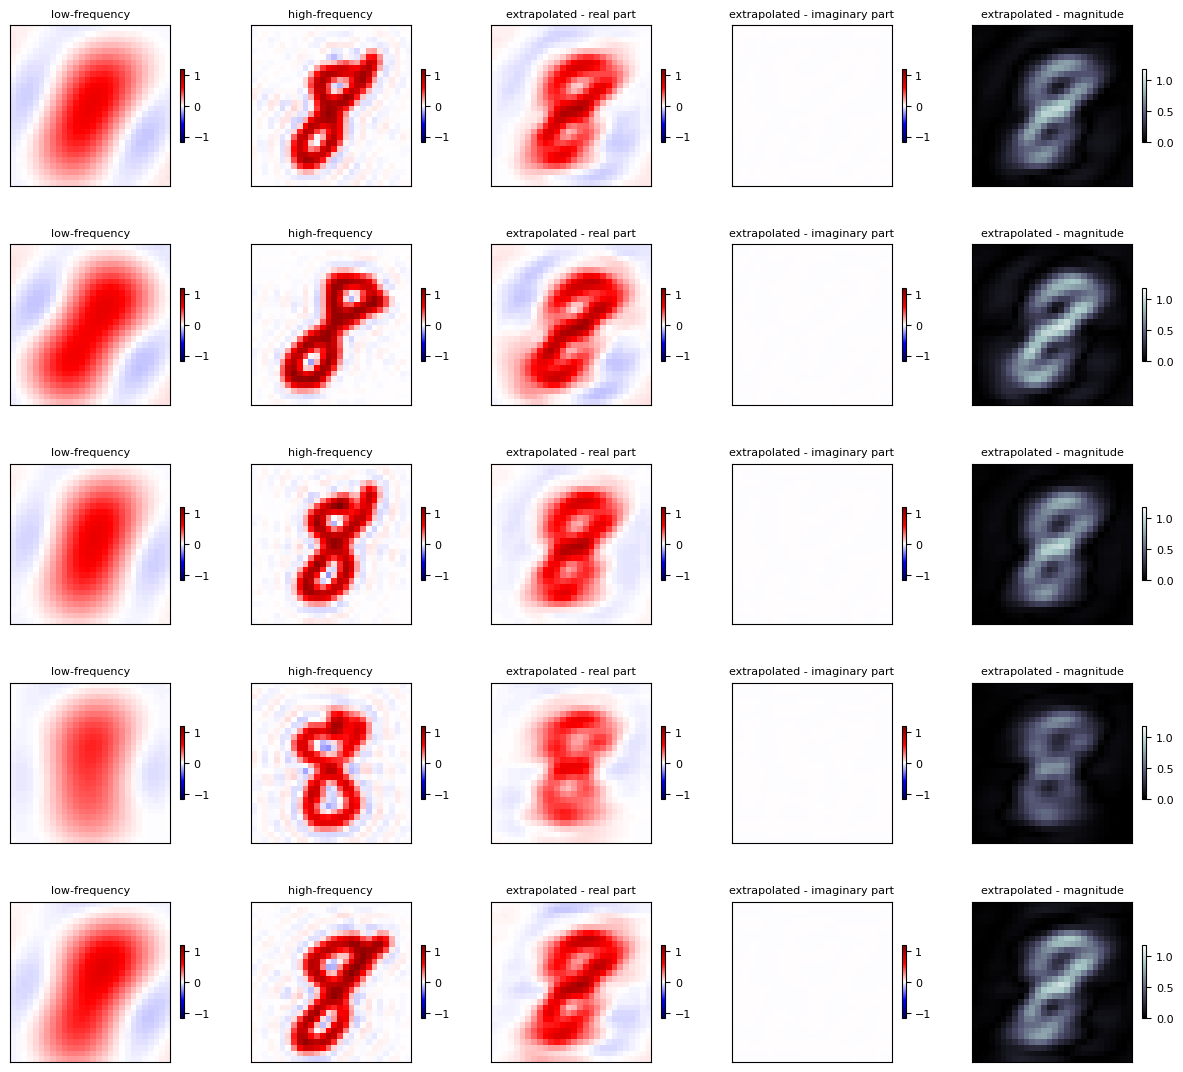

In [33]:
plt.figure(figsize=(15, 2.75 * num_imgs))
for I, (X_lo, X_hi, X_ext) in enumerate(zip(X_los, X_his, X_exts)):
  plt.subplot(num_imgs, 5, 1 + 5 * I)
  plt.imshow(X_lo, vmin=-x_max, vmax=+x_max, origin='lower', cmap='seismic')
  plt.xticks([])
  plt.yticks([])
  plt.title(f'low-frequency', fontsize=8)
  cb = plt.colorbar(shrink=0.4)
  cb.ax.tick_params(labelsize=8)
  plt.subplot(num_imgs, 5, 2 + 5 * I)
  plt.imshow(X_hi, vmin=-x_max, vmax=+x_max, origin='lower', cmap='seismic')
  plt.xticks([])
  plt.yticks([])
  plt.title(f'high-frequency', fontsize=8)
  cb = plt.colorbar(shrink=0.4)
  cb.ax.tick_params(labelsize=8)
  plt.subplot(num_imgs, 5, 3 + 5 * I)
  plt.imshow(X_ext.real, vmin=-x_max, vmax=x_max, origin='lower', cmap='seismic')
  plt.xticks([])
  plt.yticks([])
  plt.title(f'extrapolated - real part', fontsize=8)
  cb = plt.colorbar(shrink=0.4)
  cb.ax.tick_params(labelsize=8)
  plt.subplot(num_imgs, 5, 4 + 5 * I)
  plt.imshow(X_ext.imag, vmin=-x_max, vmax=x_max, origin='lower', cmap='seismic')
  plt.xticks([])
  plt.yticks([])
  plt.title(f'extrapolated - imaginary part', fontsize=8)
  cb = plt.colorbar(shrink=0.4)
  cb.ax.tick_params(labelsize=8)
  plt.subplot(num_imgs, 5, 5 + 5 * I)
  plt.imshow(np.abs(X_ext), vmin=0.0, vmax=x_max, origin='lower', cmap='bone')
  plt.xticks([])
  plt.yticks([])
  plt.title(f'extrapolated - magnitude', fontsize=8)
  cb = plt.colorbar(shrink=0.4)
  cb.ax.tick_params(labelsize=8)
plt.show()

# figures for paper ------------------------------------------------------------------------------------------
plt.ioff()
plt.figure(figsize=(12, 7))
plt.subplot(1, 3, 1)
plt.imshow(X_los[0], vmin=-x_max, vmax=+x_max, origin='lower', cmap='seismic')
plt.xticks([])
plt.yticks([])
plt.title(f'low-frequency', fontsize=14)
cb = plt.colorbar(shrink=0.2)
cb.ax.tick_params(labelsize=10)
plt.subplot(1, 3, 2)
plt.imshow(X_his[0], vmin=-x_max, vmax=+x_max, origin='lower', cmap='seismic')
plt.xticks([])
plt.yticks([])
plt.title(f'high-frequency', fontsize=14)
cb = plt.colorbar(shrink=0.2)
cb.ax.tick_params(labelsize=10)
plt.subplot(1, 3, 3)
plt.imshow(X_exts[0].real, vmin=-x_max, vmax=x_max, origin='lower', cmap='seismic')
plt.xticks([])
plt.yticks([])
plt.title(f'extrapolated', fontsize=14)
cb = plt.colorbar(shrink=0.2)
cb.ax.tick_params(labelsize=10)
savefig('EXT_X', data_digit)
plt.close()

plt.ioff()
plt.figure(figsize=(12, 7))
plt.subplot(1, 3, 1)
plt.imshow(A[0].reshape(N), vmin=0, vmax=1, origin='lower', cmap='bone')
plt.xticks([])
plt.yticks([])
plt.title(f'original', fontsize=14)
cb = plt.colorbar(shrink=0.2)
cb.ax.tick_params(labelsize=10)
plt.subplot(1, 3, 2)
plt.imshow(np.abs(X_his[0]), vmin=0, vmax=1, origin='lower', cmap='bone')
plt.xticks([])
plt.yticks([])
plt.title(f'high-frequency', fontsize=14)
cb = plt.colorbar(shrink=0.2)
cb.ax.tick_params(labelsize=10)
plt.subplot(1, 3, 3)
plt.imshow(np.abs(X_exts[0]), vmin=0, vmax=1, origin='lower', cmap='bone')
plt.xticks([])
plt.yticks([])
plt.title(f'extrapolated', fontsize=14)
cb = plt.colorbar(shrink=0.2)
cb.ax.tick_params(labelsize=10)
savefig('EXT_X_IM', data_digit)
plt.close()